# COVID-19 Case Prediction with Machine Learning

This project focuses on building and evaluating machine learning models to predict whether the number of new COVID-19 cases in Malaysia will **increase on the following day**.  

We make use of publicly available data provided by the [Ministry of Health Malaysia (MoH)](https://github.com/MoH-Malaysia/covid19-public), which includes information such as daily cases, testing statistics, and mobility check-ins.  

---

## Objective

The main goals of this project are:
- To **predict daily trends** in COVID-19 cases (increase vs. non-increase).  
- To **compare different machine learning models** in terms of predictive performance.  
- To **identify useful features and transformations** that improve prediction accuracy.  
- To **visualize results** through metrics, confusion matrices, ROC curves, and precision-recall curves.  

---

## Project Workflow

The notebook is structured into the following parts:
1. Setup: Imports and Configurations  
2. Data Preparation  
3. Feature Engineering  
4. Helper Functions  
5. Model Definitions  
6. Model Training & Evaluation  


## 1. Setup: Imports and Configuration

We start by importing the required libraries and defining project-wide constants.

### Imports
- **Data handling & computation**  
  - `pandas` for dataframes and preprocessing  
  - `numpy` for numerical operations  

- **Visualization**  
  - `matplotlib` and `seaborn` for plots and charts  

- **Time tracking**  
  - `time` for measuring training and inference durations  

- **Machine Learning Models**  
  - `LogisticRegression` (linear model for classification)  
  - `RandomForestClassifier` (ensemble learning)  
  - `KNeighborsClassifier` (distance-based classification)  
  - `PCA` (dimensionality reduction, though optional in this workflow)  
  - `xgboost` (gradient boosting framework)  

- **Model training & preprocessing tools**  
  - `TimeSeriesSplit` for cross-validation on time-dependent data  
  - `GridSearchCV` for hyperparameter tuning  
  - `StandardScaler`, `PowerTransformer`, `QuantileTransformer` for preprocessing  
  - `Pipeline` for chaining preprocessing and model steps  

- **Evaluation metrics**  
  - Accuracy, Precision, Recall, F1-score  
  - Confusion Matrix, Classification Report  
  - ROC-AUC, ROC curve, Precision-Recall curve  

### Constants and Configuration
- **Data source**  
  - COVID-19 datasets are pulled from the [Ministry of Health Malaysia’s GitHub repository](https://github.com/MoH-Mal)


In [47]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)

# CONSTANTS AND CONFIG
BASE_URL = "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/"
TARGET = "cases_new_increase_tmr"
START_DATE = pd.to_datetime("2021-07-02")
END_DATE = START_DATE + pd.DateOffset(months=6)
NO_DAYS = (END_DATE - START_DATE).days + 1
dates = pd.date_range(start=START_DATE, end=END_DATE, freq="D")
print(f"No. days: {NO_DAYS}")
print(f"Date range: {START_DATE} to {END_DATE}")

No. days: 185
Date range: 2021-07-02 00:00:00 to 2022-01-02 00:00:00


## 2. Data Preparation

In this section, we load and prepare the raw COVID-19 datasets for modeling.

### 2.1 Data Loading
- Data files used:  
  - `cases_malaysia.csv` (daily reported cases)  
  - `tests_malaysia.csv` (PCR and antigen tests)  
  - `checkin_malaysia.csv` (mobility check-ins via MySejahtera app)  
- Files are loaded directly from the official GitHub repository into Pandas DataFrames.

### 2.2 Data Cleaning & Preprocessing
- Convert the `date` column to datetime format.  
- Filter rows to only include dates within the defined analysis period.  
- Drop columns that are entirely null.  
- Remove columns containing only a single unique value.  
- Save the cleaned DataFrames for further processing.

### 2.3 Data Merging
- Start with a base DataFrame containing the analysis date range.  
- Merge each dataset on the `date` column.  
- For datasets with multiple entries per day, aggregate values by summing across states.  
- Result: one consolidated dataset covering daily cases, tests, and mobility statistics.


In [48]:
# DATA PREPERATION

# Data loading
files = {
    "cases_malaysia": BASE_URL + "epidemic/cases_malaysia.csv",
    "tests_malaysia": BASE_URL + "epidemic/tests_malaysia.csv",
    "checkin_malaysia": BASE_URL + "mysejahtera/checkin_malaysia.csv",
}
dfs = {name: pd.read_csv(url) for name, url in files.items()}

# Data cleaning & preprocessing
for k, df in dfs.items():
    # Set date column as datetime and filter the dates
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)]

    # Drop columns where all values are null
    df = df.dropna(axis=1, how="all")

    # Remove columns with one value only
    df = df.loc[:, df.nunique(dropna=True) > 1]

    # Save back into dictionary
    dfs[k] = df

    # Check shape
    output_filename = f"{k}.csv"
    print(f"{k}: {df.shape}")

# Data merging
data = pd.DataFrame({'date': dates})
for k, df in dfs.items():
    # Group data by date if multiple data per date
    if df.shape[0] != NO_DAYS:
        df = df.drop(columns=["state"])
        df = df.groupby("date").sum()

    # Merge data
    data = pd.merge(data, df, on="date", how="left")

cases_malaysia: (185, 24)
tests_malaysia: (185, 3)
checkin_malaysia: (185, 4)


## 3. Feature Engineering

Once the datasets are merged, we create new features to enhance the predictive power of our models.

### 3.1 Target Variable
- `cases_new_increase_tmr`: a binary label indicating whether tomorrow’s new cases are **greater than today’s**.  
- The last row is dropped since it lacks a target value.

### 3.2 Base Features
- Selected directly from the dataset:  
  - `cases_new`  
  - `cases_active`  
  - `cases_cluster`  
  - `tests_total`  
  - `mobility_density`  

### 3.3 Combined Features
- **Testing feature**:  
  - `tests_total = rtk-ag + pcr`  
- **Mobility feature**:  
  - `mobility_density = checkins / unique_loc`  
  - Infinite and missing values are replaced with `0`.

### 3.4 Lagging and Rolling Features
For each base feature:
- **Lag features**: previous day’s value (e.g., `cases_new_shift1`).  
- **Rolling averages**: 7-day moving average (e.g., `cases_new_7d_avg`).  
- **Percent change**: day-to-day percentage change (e.g., `cases_new_pct_change`).  

### 3.5 Additional Features
- **Day of the week**: numeric value from 0 (Monday) to 6 (Sunday).

### 3.6 Final Dataset
- Rows with `NaN` values (introduced by lagging/rolling) are removed.  
- `X`: feature matrix containing engineered features.  
- `y`: target vector (`cases_new_increase_tmr`).  
- Summary statistics such as dataset shapes and target distribution are displayed.


In [49]:
# FEATURE ENGINEERING

# Include target cases_new_increase_tmr
data["cases_new_increase_tmr"] = (
    data["cases_new"].shift(-1) > data["cases_new"]
).astype(int)

# Drop last row (no target)
data = data[:-1]

# Features selection
base_features = [
    "cases_new",
    "cases_active",
    "cases_cluster",
    "tests_total",
    "mobility_density",
]
feature_cols = base_features.copy()

# Create combined features
data["tests_total"] = data["rtk-ag"] + data["pcr"] 
data["mobility_density"] = data["checkins"] / data["unique_loc"]
data["mobility_density"] = (
    data["mobility_density"].replace([float("inf"), -float("inf")], 0).fillna(0)
)

# Create lagging features
lag_days = [1]
for col in base_features:
    # Lag features
    for day in lag_days:
        feat_name = f"{col}_shift{day}"
        data[feat_name] = data[col].shift(day)  # previous day
        feature_cols.append(feat_name)

    # Rolling averages (7-day)
    feat_name = f"{col}_7d_avg"
    data[feat_name] = data[col].rolling(window=7).mean()  # 7-day avg
    feature_cols.append(feat_name)

    # Percent change
    feat_name = f"{col}_pct_change"
    data[feat_name] = data[col].pct_change()  # daily pct change
    feature_cols.append(feat_name)

# Create a new feature Day of week
data["day_of_week"] = data["date"].dt.dayofweek  # 0=Monday, 6=Sunday
feature_cols.append("day_of_week")

# Drop rows with NaN caused by lag/rolling
data = data.dropna().reset_index(drop=True)

# Set target and features
y = data["cases_new_increase_tmr"]
X = data[feature_cols]

# Output shapes
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y distribution: ", y.value_counts())
print("Selected features:", feature_cols)

X shape: (178, 21)
y shape: (178,)
y distribution:  cases_new_increase_tmr
0    94
1    84
Name: count, dtype: int64
Selected features: ['cases_new', 'cases_active', 'cases_cluster', 'tests_total', 'mobility_density', 'cases_new_shift1', 'cases_new_7d_avg', 'cases_new_pct_change', 'cases_active_shift1', 'cases_active_7d_avg', 'cases_active_pct_change', 'cases_cluster_shift1', 'cases_cluster_7d_avg', 'cases_cluster_pct_change', 'tests_total_shift1', 'tests_total_7d_avg', 'tests_total_pct_change', 'mobility_density_shift1', 'mobility_density_7d_avg', 'mobility_density_pct_change', 'day_of_week']


## 4. Helper Functions

To keep the workflow modular and reusable, several helper functions are defined.

### 4.1 Data Splitting
- **`split_time_series_data`**  
  - Splits the dataset into a development set and a final test set.  
  - Uses a fraction (e.g., 15%) of the most recent data as the test set, preserving time order.

### 4.2 Visualization
- **`plot_feature_distributions_before_after`**  
  - Compares feature distributions before and after transformations (e.g., scaling).  
  - Plots histograms with KDEs in a grid layout for easy side-by-side comparison.

### 4.3 Pipeline Utilities
- **`build_pipeline`**  
  - Builds a preprocessing + model pipeline.  
  - Supports transformations: *Yeo-Johnson*, *Box-Cox*, or *Quantile transformation*.  
  - Standard scaling is always applied before passing data to the model.  

- **`adjust_param_grid`**  
  - Adjusts parameter grid keys to be compatible with pipelines (prefixing with `model__`).  

### 4.4 Model Training
- **`train_with_gridsearch`**  
  - Runs `GridSearchCV` with `TimeSeriesSplit` cross-validation.  
  - Evaluates multiple metrics: accuracy, precision, recall, F1, and ROC-AUC.  
  - Returns the fitted grid search object and training time statistics.  

- **`count_param_combinations`**  
  - Counts the total number of parameter combinations tested during grid search.  

### 4.5 Metrics and Evaluation
- **`compute_avg_metrics_from_grid`**  
  - Extracts cross-validation average metrics from the grid search results.  

- **`evaluate_model`**  
  - Evaluates a trained model on the test set.  
  - Finds the best probability threshold based on F1-score.  
  - Computes and displays confusion matrices, classification reports, ROC curves, PR curves, and probability distributions.  
  - Returns detailed evaluation results in Pandas DataFrames.  

### 4.6 End-to-End Training
- **`train_evaluate_model`**  
  - Combines all steps: splitting, building pipeline, grid search training, feature distribution plots, and test evaluation.  
  - Returns evaluation results and average cross-validation metrics.  


In [50]:
# HELPER FUNCTIONS

def split_time_series_data(X, y, test_fraction=0.15):
    """Split time series data into development and final test sets."""
    n_samples = len(X)
    test_size = max(1, int(n_samples * test_fraction))
    X_dev, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_dev, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    return X_dev, X_test, y_dev, y_test

def plot_feature_distributions_before_after(
    X_before, X_after, title_before="Before", title_after="After"
):
    """
    Plot feature distributions side by side (before vs after) in 6-column layout.
    Each row shows 3 features, with 'Before' and 'After' plots next to each other.
    """
    # Ensure DataFrames
    cols = (
        X_before.columns
        if hasattr(X_before, "columns")
        else [f"f{i}" for i in range(X_before.shape[1])]
    )
    df_before = pd.DataFrame(X_before, columns=cols)
    df_after = pd.DataFrame(X_after, columns=cols)

    n_features = df_before.shape[1]
    n_pairs = int(np.ceil(n_features / 3))  # 3 features per row → 6 plots

    fig, axes = plt.subplots(n_pairs, 6, figsize=(22, 3 * n_pairs))
    if n_pairs == 1:
        axes = np.array([axes])  # keep 2D structure
    axes = axes.reshape(n_pairs, 6)

    for i, col in enumerate(cols):
        row = i // 3
        col_pos = (i % 3) * 2  # 0, 2, 4 → feature pairs in row

        # Before
        sns.histplot(
            df_before[col], bins=20, kde=True, ax=axes[row, col_pos], color="blue"
        )
        axes[row, col_pos].set_title(f"{col} - {title_before}")

        # After
        sns.histplot(
            df_after[col], bins=20, kde=True, ax=axes[row, col_pos + 1], color="orange"
        )
        axes[row, col_pos + 1].set_title(f"{col} - {title_after}")

    # Remove unused subplots if features < full grid
    total_slots = n_pairs * 3
    for j in range(n_features, total_slots):
        row = j // 3
        col_pos = (j % 3) * 2
        fig.delaxes(axes[row, col_pos])
        fig.delaxes(axes[row, col_pos + 1])

    plt.suptitle(
        "Feature Distributions - Before vs After Transformation", fontsize=16, y=1.02
    )
    plt.tight_layout(pad=2.0)
    plt.show()

def build_pipeline(model, transform="yeo-johnson"):
    """Build preprocessing + model pipeline."""
    steps = []
    if transform in ["yeo-johnson", "box-cox"]:
        steps.append(("transform", PowerTransformer(method=transform)))
    elif transform == "quantile":
        steps.append(("transform", QuantileTransformer(output_distribution="normal")))
    steps.append(("scaler", StandardScaler()))
    steps.append(("model", model))
    return Pipeline(steps)

def adjust_param_grid(param_grid):
    """Prefix param grid with 'model__' for use inside Pipeline."""
    if isinstance(param_grid, list):  # list of dicts
        return [{f"model__{k}": v for k, v in grid.items()} for grid in param_grid]
    return {f"model__{k}": v for k, v in param_grid.items()}

def train_with_gridsearch(pipeline, param_grid, X_dev, y_dev, n_splits=5):
    """Run GridSearchCV with TimeSeriesSplit using multiple metrics, return avg time per param set."""
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc"
    }
    
    n_param_sets = count_param_combinations(param_grid)
    
    start_time = time.time()
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=tscv,
        scoring=scoring,
        refit="f1",
        n_jobs=-1
    )
    grid.fit(X_dev, y_dev)
    total_train_time = time.time() - start_time

    avg_train_time_per_param = total_train_time / n_param_sets if n_param_sets > 0 else np.nan
    
    return grid, total_train_time, avg_train_time_per_param

def compute_avg_metrics_from_grid(grid):
    """
    Compute average metrics across CV folds from GridSearchCV (multi-metric).
    
    Returns a dict with:
        - average_accuracy
        - average_precision
        - average_recall
        - average_f1
        - average_roc_auc (if available)
    """
    results = grid.cv_results_
    avg_metrics = {}

    # Loop through expected metrics
    for metric_name in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        key = f"mean_test_{metric_name}"
        if key in results:
            avg_metrics[f"average_{metric_name}"] = results[key][grid.best_index_]
        else:
            avg_metrics[f"average_{metric_name}"] = np.nan

    return avg_metrics

def evaluate_model(model, X_test, y_test, model_name, train_time, best_params):
    """Evaluate model on test set, return metrics + plots, using best threshold (F1)."""

    start_infer = time.time()
    y_prob = (
        model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    )
    infer_time = time.time() - start_infer

    # --- Determine best threshold for F1 ---
    best_threshold, best_f1, best_prec, best_rec, best_acc = 0.5, None, None, None, None
    y_pred_best = model.predict(X_test)
    if y_prob is not None:
        thresholds = np.linspace(0, 1, 101)
        f1_scores, precisions, recalls, accuracies = [], [], [], []

        for t in thresholds:
            y_pred_t = (y_prob >= t).astype(int)
            f1_scores.append(f1_score(y_test, y_pred_t, zero_division=0))
            precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
            recalls.append(recall_score(y_test, y_pred_t, zero_division=0))
            accuracies.append(accuracy_score(y_test, y_pred_t))

        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]
        best_prec = precisions[best_idx]
        best_rec = recalls[best_idx]
        best_acc = accuracies[best_idx]
        y_pred_best = (y_prob >= best_threshold).astype(int)

    # --- Metrics ---
    cm_best = confusion_matrix(y_test, y_pred_best)
    cm_norm_best = cm_best.astype("float") / cm_best.sum(axis=1)[:, np.newaxis]
    report_best = classification_report(y_test, y_pred_best)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    roc_auc_str = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"

    # --- Plots (ConfMat, ROC, PR, ProbDist) ---
    fig, axes = plt.subplots(1, 4, figsize=(28, 5))

    # Confusion matrix (counts + normalized)
    annot = np.empty_like(cm_best).astype(str)
    for i in range(cm_best.shape[0]):
        for j in range(cm_best.shape[1]):
            annot[i, j] = f"{cm_best[i,j]}\n({cm_norm_best[i,j]:.2f})"

    sns.heatmap(
        cm_norm_best, annot=annot, fmt="", cmap="Blues", ax=axes[0], cbar=False
    )
    axes[0].set_title(f"Confusion Matrix\n(Best Threshold = {best_threshold:.2f})")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    if y_prob is not None:
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        axes[1].plot([0, 1], [0, 1], "k--")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title("ROC Curve")
        axes[1].legend()

        # Precision-Recall curve
        prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_prob)
        axes[2].plot(rec_curve, prec_curve)
        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")
        axes[2].set_title("Precision-Recall Curve")

        # Probability distribution
        axes[3].hist(y_prob[y_test == 0], bins=20, alpha=0.6, label="Class 0")
        axes[3].hist(y_prob[y_test == 1], bins=20, alpha=0.6, label="Class 1")
        axes[3].set_xlabel("Predicted Probability")
        axes[3].set_ylabel("Frequency")
        axes[3].set_title("Probability Distribution")
        axes[3].legend()

    plt.suptitle(f"{model_name} - Evaluation Plots", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

    # --- Summary ---
    summary = f"""
=== {model_name} Evaluation Summary ===
Best Params: {best_params}

Best Threshold (by F1): {best_threshold:.2f}
    Accuracy : {best_acc:.4f}
    Precision: {best_prec:.4f}
    Recall   : {best_rec:.4f}
    F1-Score : {best_f1:.4f}
    ROC-AUC  : {roc_auc_str}

Confusion Matrix (Counts):
{cm_best}

Confusion Matrix (Normalized):
{np.array2string(cm_norm_best, precision=2, floatmode="fixed")}

Classification Report:
{report_best}

Training Time : {train_time:.2f} sec
Inference Time: {infer_time:.4f} sec
========================================
"""
    print(summary)

    # --- Package results ---
    df_results = pd.DataFrame(
        [
            {
                "model": model_name,
                "accuracy": best_acc,
                "precision": best_prec,
                "recall": best_rec,
                "f1_score": best_f1,
                "roc_auc": roc_auc,
                "best_params": best_params,
                "best_threshold": best_threshold,
                "train_time_sec": train_time,
                "infer_time_sec": infer_time,
                "confusion_matrix": cm_best,
                "classification_report": report_best,
            }
        ]
    )

    df_avg = pd.DataFrame(
        [
            {
                "model": model_name,
                "average_accuracy": best_acc,
                "average_precision": best_prec,
                "average_recall": best_rec,
                "average_f1": best_f1,
                "average_roc_auc": roc_auc,
                "avg_train_time_sec": train_time,
                "avg_infer_time_sec": infer_time,
            }
        ]
    )

    return df_results, df_avg

def count_param_combinations(param_grid):
    """Count total number of parameter combinations for GridSearchCV."""
    if isinstance(param_grid, list):  # list of dicts
        total = 0
        for grid in param_grid:
            lengths = [len(v) if isinstance(v, (list, np.ndarray)) else 1 for v in grid.values()]
            total += np.prod(lengths)
        return total
    else:  # single dict
        lengths = [len(v) if isinstance(v, (list, np.ndarray)) else 1 for v in param_grid.values()]
        return np.prod(lengths)

def train_evaluate_model(
    model, param_grid, X, y, n_splits=5, test_fraction=0.15, transform="yeo-johnson"
):
    model_name = type(model).__name__
    print(f"\n=== Training {model_name} with TimeSeriesSplit ===")

    # --- Split data ---
    X_dev, X_test, y_dev, y_test = split_time_series_data(X, y, test_fraction)

    # --- Build pipeline and parameter grid ---
    pipeline = build_pipeline(model, transform)
    param_grid_pipeline = adjust_param_grid(param_grid)

    # --- Train with GridSearchCV ---
    grid, total_train_time, avg_train_time_per_param = train_with_gridsearch(
        pipeline, param_grid_pipeline, X_dev, y_dev, n_splits
    )
    best_model = grid.best_estimator_

    # --- Compute average metrics from CV folds ---
    avg_metrics = compute_avg_metrics_from_grid(grid)
    df_avg = pd.DataFrame(
        [
            {
                "model": model_name,
                "average_accuracy": avg_metrics.get("average_accuracy", np.nan),
                "average_precision": avg_metrics.get("average_precision", np.nan),
                "average_recall": avg_metrics.get("average_recall", np.nan),
                "average_f1": avg_metrics.get("average_f1", np.nan),
                "average_roc_auc": avg_metrics.get("average_roc_auc", np.nan),
                "total_train_time_sec": total_train_time,
                "avg_train_time_per_param_sec": avg_train_time_per_param,
            }
        ]
    )

    # --- Plot feature distributions before vs after transformation ---
    X_dev_transformed = best_model[:-1].transform(X_dev)
    plot_feature_distributions_before_after(X_dev, X_dev_transformed)

    # --- Evaluate on test set ---
    df_results, df_test_avg = evaluate_model(
        best_model, X_test, y_test, model_name, total_train_time, grid.best_params_
    )

    print(f"\n=== Finished {model_name} ===")
    return df_results, df_avg  # df_avg is CV average including avg train time per param


## 5. Model Definitions

We define the machine learning models to be trained, along with their respective hyperparameter grids for tuning.

### 5.1 Models
Four classification models are considered:

1. **Logistic Regression**  
   - Linear baseline model.  
   - Configured with `class_weight="balanced"` to handle class imbalance.  

2. **K-Nearest Neighbors (KNN)**  
   - Distance-based classifier.  
   - Sensitive to scaling, hence preprocessing is important.  

3. **Random Forest Classifier**  
   - Ensemble of decision trees using bootstrap aggregation.  
   - Configured with `class_weight="balanced"` and parallelized with `n_jobs=-1`.  

4. **XGBoost Classifier**  
   - Gradient boosting framework optimized for speed and performance.  
   - Configured with `scale_pos_weight` to address class imbalance.  

### 5.2 Hyperparameter Grids
Each model has a grid of hyperparameters for `GridSearchCV` to explore:

- **Logistic Regression**  
  - `penalty`: L2 or ElasticNet  
  - `solver`: saga  
  - `C`: inverse regularization strength (logarithmic scale)  
  - `l1_ratio`: ElasticNet mixing parameter (only when penalty = elasticnet)  

- **KNN**  
  - `n_neighbors`: number of neighbors (3, 5, 7, 9)  
  - `weights`: uniform or distance-based  
  - `metric`: distance metric (euclidean, manhattan)  

- **Random Forest**  
  - `n_estimators`: number of trees (200, 300, 400)  
  - `max_depth`: tree depth (5, 7, 9)  
  - `min_samples_split`: minimum samples to split (2, 3)  
  - `min_samples_leaf`: minimum samples at leaf (1, 2, 3)  
  - `max_features`: feature subset strategy (`sqrt`)  

- **XGBoost**  
  - `n_estimators`: boosting rounds (100, 200)  
  - `max_depth`: tree depth (2, 3, 4)  
  - `learning_rate`: step size shrinkage (0.01, 0.025, 0.05)  
  - `subsample`: row sampling ratio (0.6, 0.7, 0.8)  
  - `colsample_bytree`: column sampling ratio (0.7, 1.0)  
  - `gamma`: minimum loss reduction (0, 1.5)  
  - `reg_alpha`: L1 regularization (0, 1, 1.5)  
  - `reg_lambda`: L2 regularization (1, 3)  


In [51]:
# MODEL DEFINITIONS

# Define models
random_state = 42
models = {
    "LogisticRegression": LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        random_state=random_state,
    ),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(
        class_weight="balanced",
        n_jobs=-1,
        random_state=random_state,
    ),
    "XGB": xgb.XGBClassifier(
        eval_metric="aucpr",
        scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),
        n_jobs=-1,
        verbosity=0,
        random_state=random_state,
    ),
}

# Define param grids
param_grids = {
    "LogisticRegression": [
        {  # L2 penalty
            "penalty": ["l2"],
            "solver": ["saga"],
            "C": np.logspace(-0.3, 0.5, 10),
        },
        {  # ElasticNet
            "penalty": ["elasticnet"],
            "solver": ["saga"],
            "C": np.logspace(-0.3, 0.5, 10),
            "l1_ratio": np.linspace(0.1, 0.4, 15),
        },
    ],
    "KNN": {
        "n_neighbors": [3, 5, 7, 9], 
        "weights": ["uniform", "distance"], 
        "metric": ["euclidean", "manhattan"], 
    },
    "RandomForest": {
        "n_estimators": [200, 300, 400],
        "max_depth": [5, 7, 9],
        "min_samples_split": [2, 3],
        "min_samples_leaf": [1, 2, 3],
        "max_features": ["sqrt"],
    },
    "XGB": {
        "n_estimators": [100, 200],
        "max_depth": [2, 3, 4],
        "learning_rate": [0.01, 0.025, 0.05],
        "subsample": [0.6, 0.7, 0.8],
        "colsample_bytree": [0.7, 1.0],
        "gamma": [0, 1.5],
        "reg_alpha": [0, 1, 1.5],
        "reg_lambda": [1, 3],
    },
}

## 6. Model Training & Evaluation

With the models and parameter grids defined, we proceed to training and evaluation.

### 6.1 Training Loop
- Each model is trained sequentially.  
- For Logistic Regression, the **Yeo-Johnson transformation** is applied during preprocessing.  
- Other models are trained without additional transformations.  
- The function `train_evaluate_model` handles:  
  - Time series data splitting (train/dev vs. test).  
  - Grid search hyperparameter tuning with cross-validation.  
  - Feature transformation visualization (before vs. after preprocessing).  
  - Final evaluation on the holdout test set.  

### 6.2 Evaluation Metrics
For each model, the following are computed:
- **Best threshold (by F1-score)** instead of default 0.5.  
- **Accuracy, Precision, Recall, F1-score, ROC-AUC**.  
- **Confusion matrices** (counts and normalized).  
- **Classification report** (per-class precision, recall, and F1).  
- **Training and inference time**.  

Visualizations include:
- Confusion Matrix heatmap.  
- ROC Curve with AUC score.  
- Precision-Recall Curve.  
- Probability Distribution by class.  

### 6.3 Results Collection
- Results for each model are stored in two DataFrames:  
  - **Detailed results** (per model, per run).  
  - **Average metrics** (summary across models).  

- Finally, the results are concatenated and displayed side by side for comparison:
  - Per-model evaluation metrics.  
  - Average metrics across models.  



--- Running LogisticRegression ---

=== Training LogisticRegression with TimeSeriesSplit ===


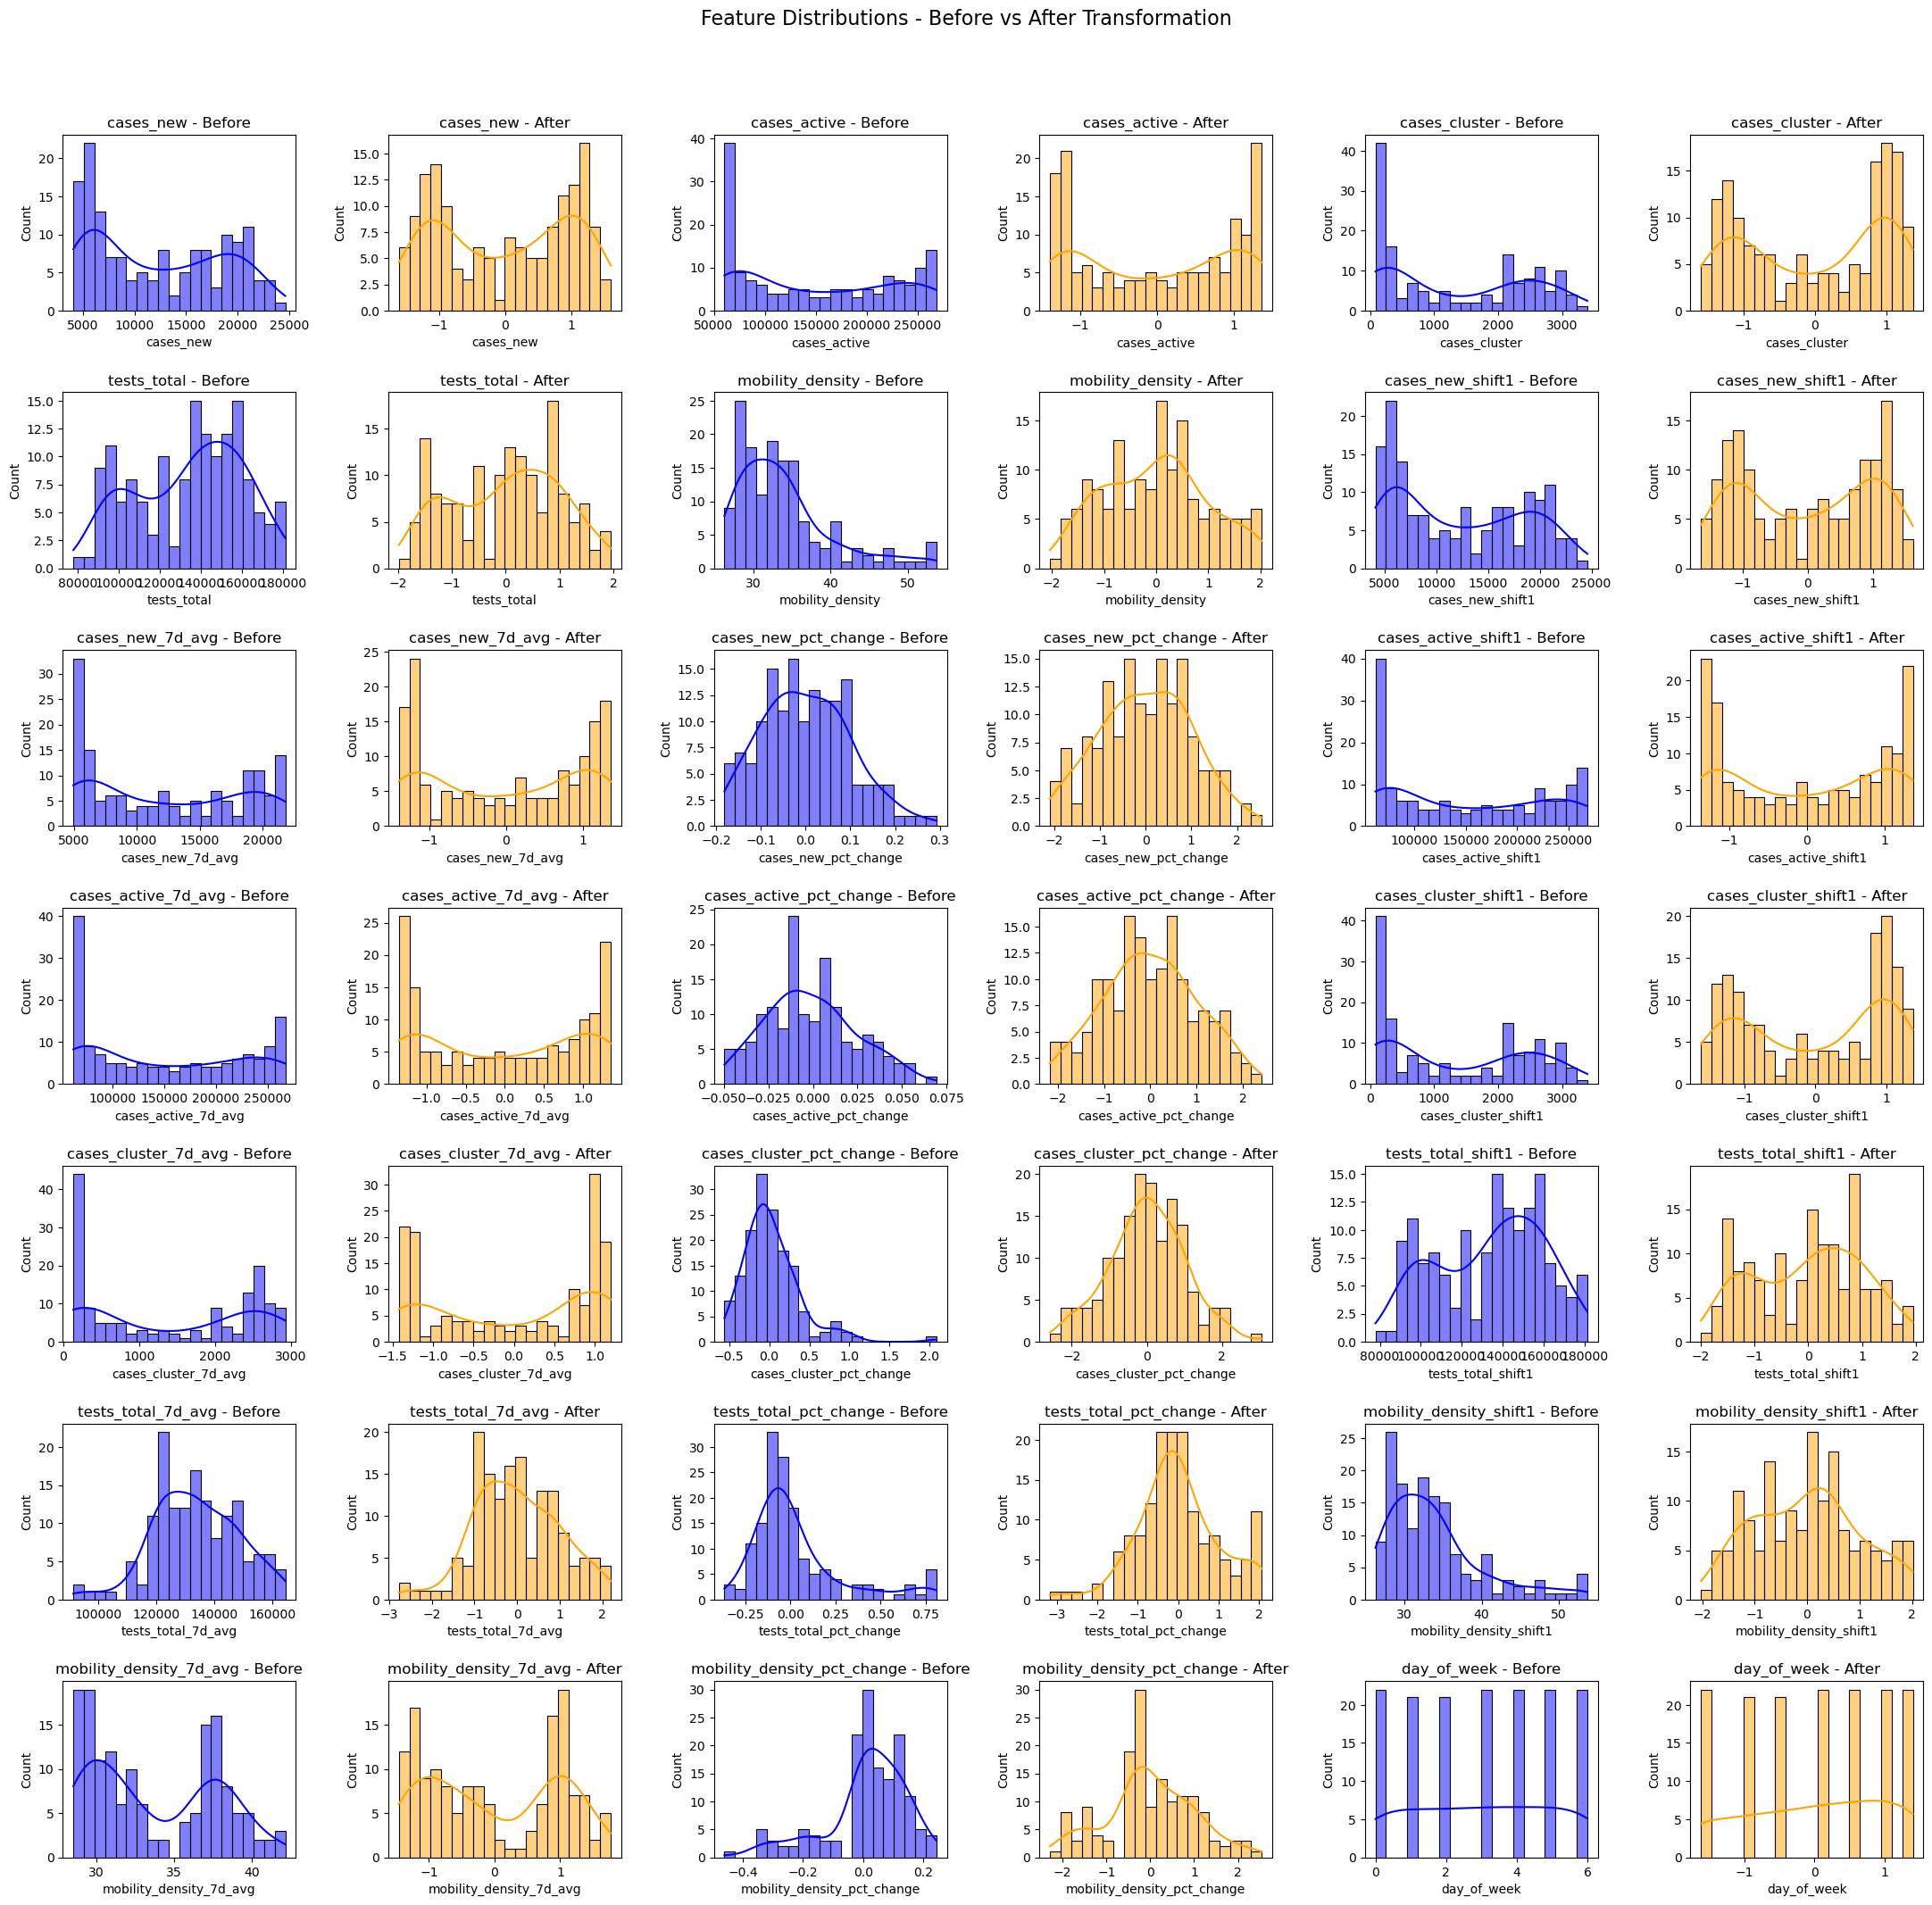

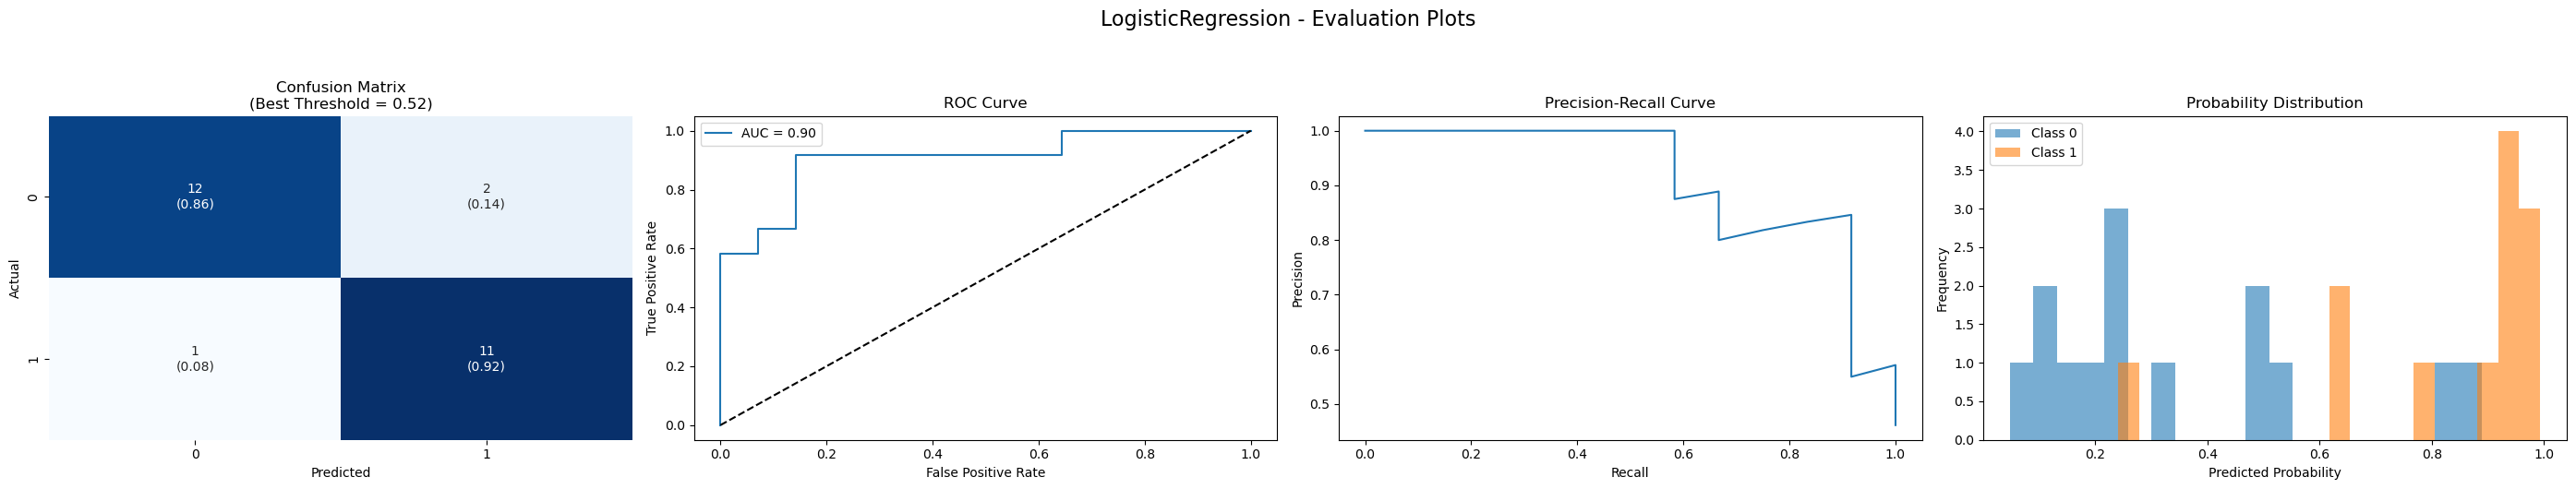


=== LogisticRegression Evaluation Summary ===
Best Params: {'model__C': 0.5011872336272722, 'model__l1_ratio': 0.20714285714285718, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}

Best Threshold (by F1): 0.52
    Accuracy : 0.8846
    Precision: 0.8462
    Recall   : 0.9167
    F1-Score : 0.8800
    ROC-AUC  : 0.9048

Confusion Matrix (Counts):
[[12  2]
 [ 1 11]]

Confusion Matrix (Normalized):
[[0.86 0.14]
 [0.08 0.92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.85      0.92      0.88        12

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.88        26


Training Time : 8.28 sec
Inference Time: 0.0033 sec


=== Finished LogisticRegression ===

--- Running KNN ---

=== Training KNeighborsClassifier with TimeSeriesSplit ===


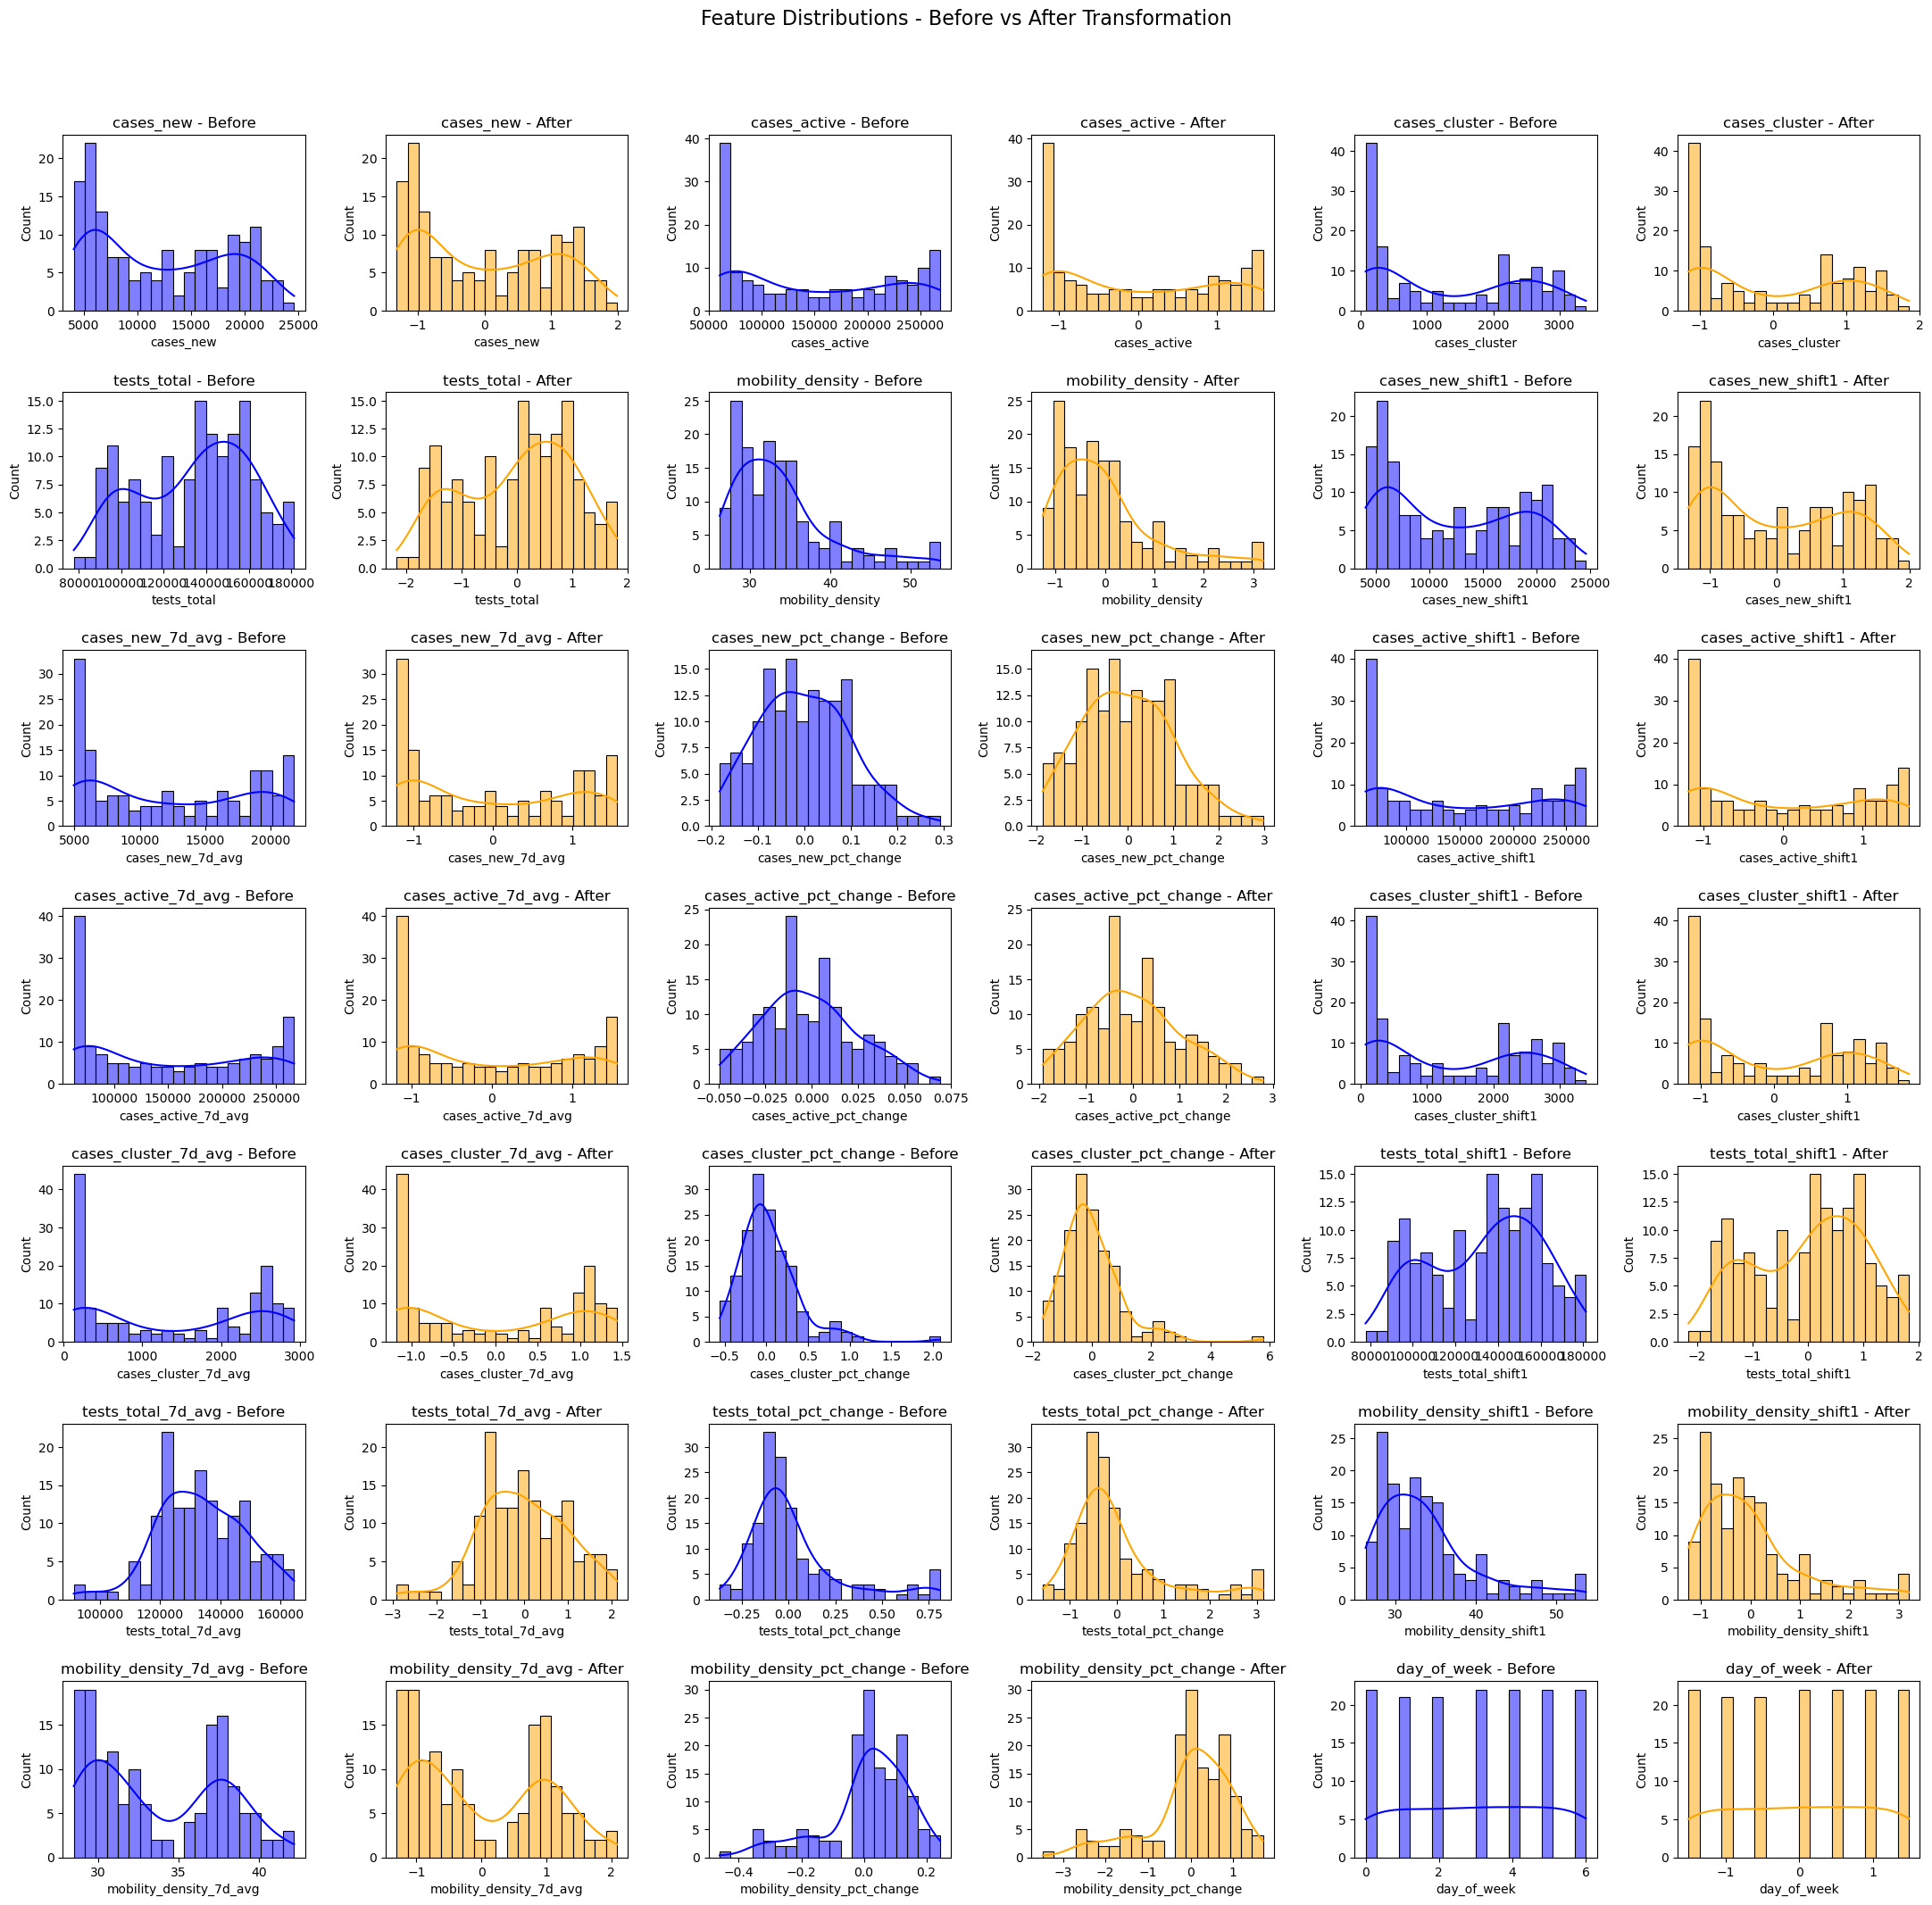

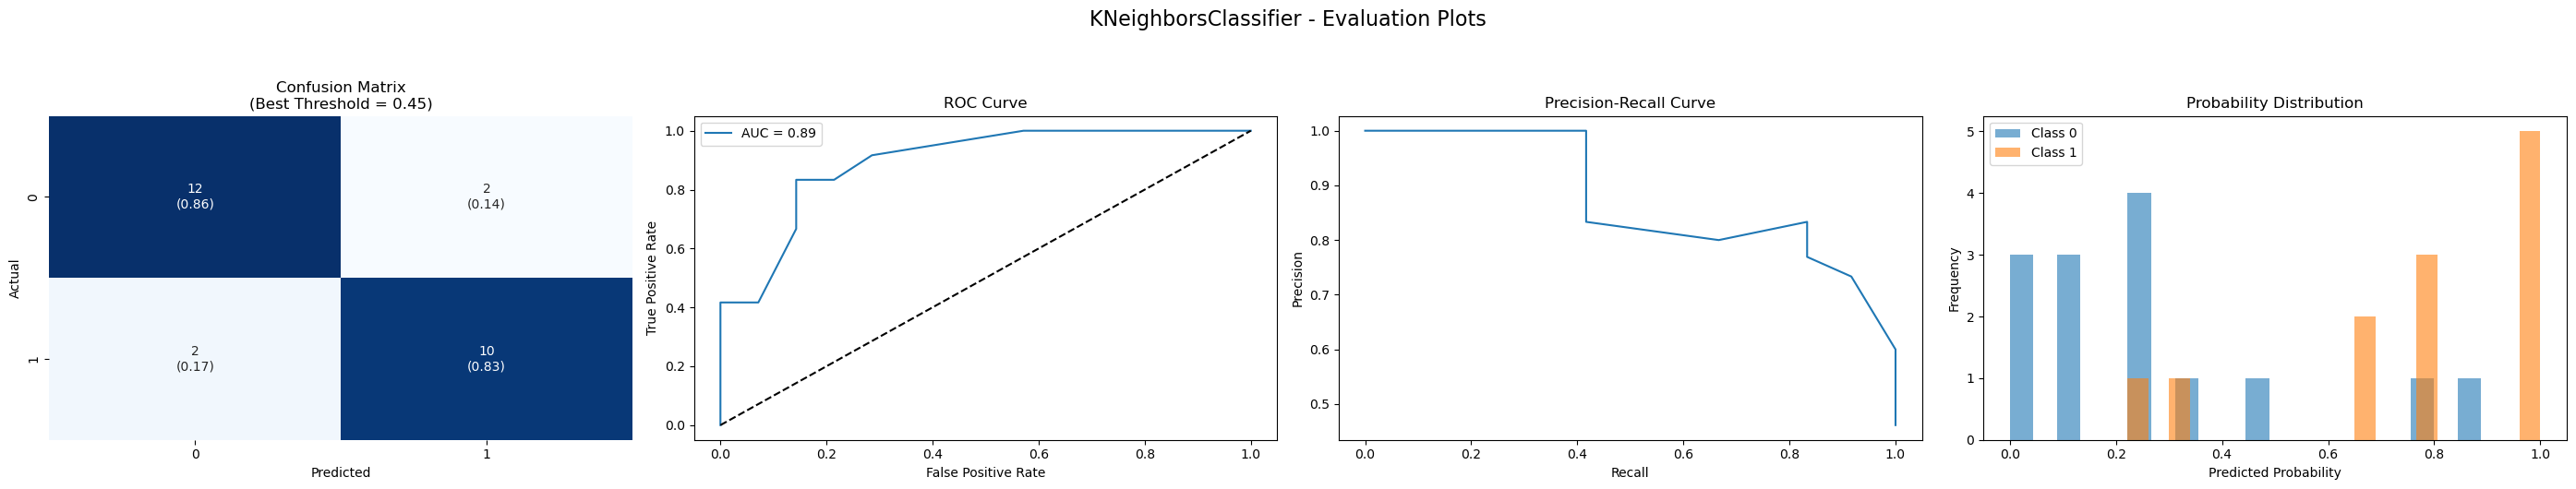


=== KNeighborsClassifier Evaluation Summary ===
Best Params: {'model__metric': 'manhattan', 'model__n_neighbors': 9, 'model__weights': 'uniform'}

Best Threshold (by F1): 0.45
    Accuracy : 0.8462
    Precision: 0.8333
    Recall   : 0.8333
    F1-Score : 0.8333
    ROC-AUC  : 0.8929

Confusion Matrix (Counts):
[[12  2]
 [ 2 10]]

Confusion Matrix (Normalized):
[[0.86 0.14]
 [0.17 0.83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.83      0.83      0.83        12

    accuracy                           0.85        26
   macro avg       0.85      0.85      0.85        26
weighted avg       0.85      0.85      0.85        26


Training Time : 0.35 sec
Inference Time: 0.0065 sec


=== Finished KNeighborsClassifier ===

--- Running RandomForest ---

=== Training RandomForestClassifier with TimeSeriesSplit ===


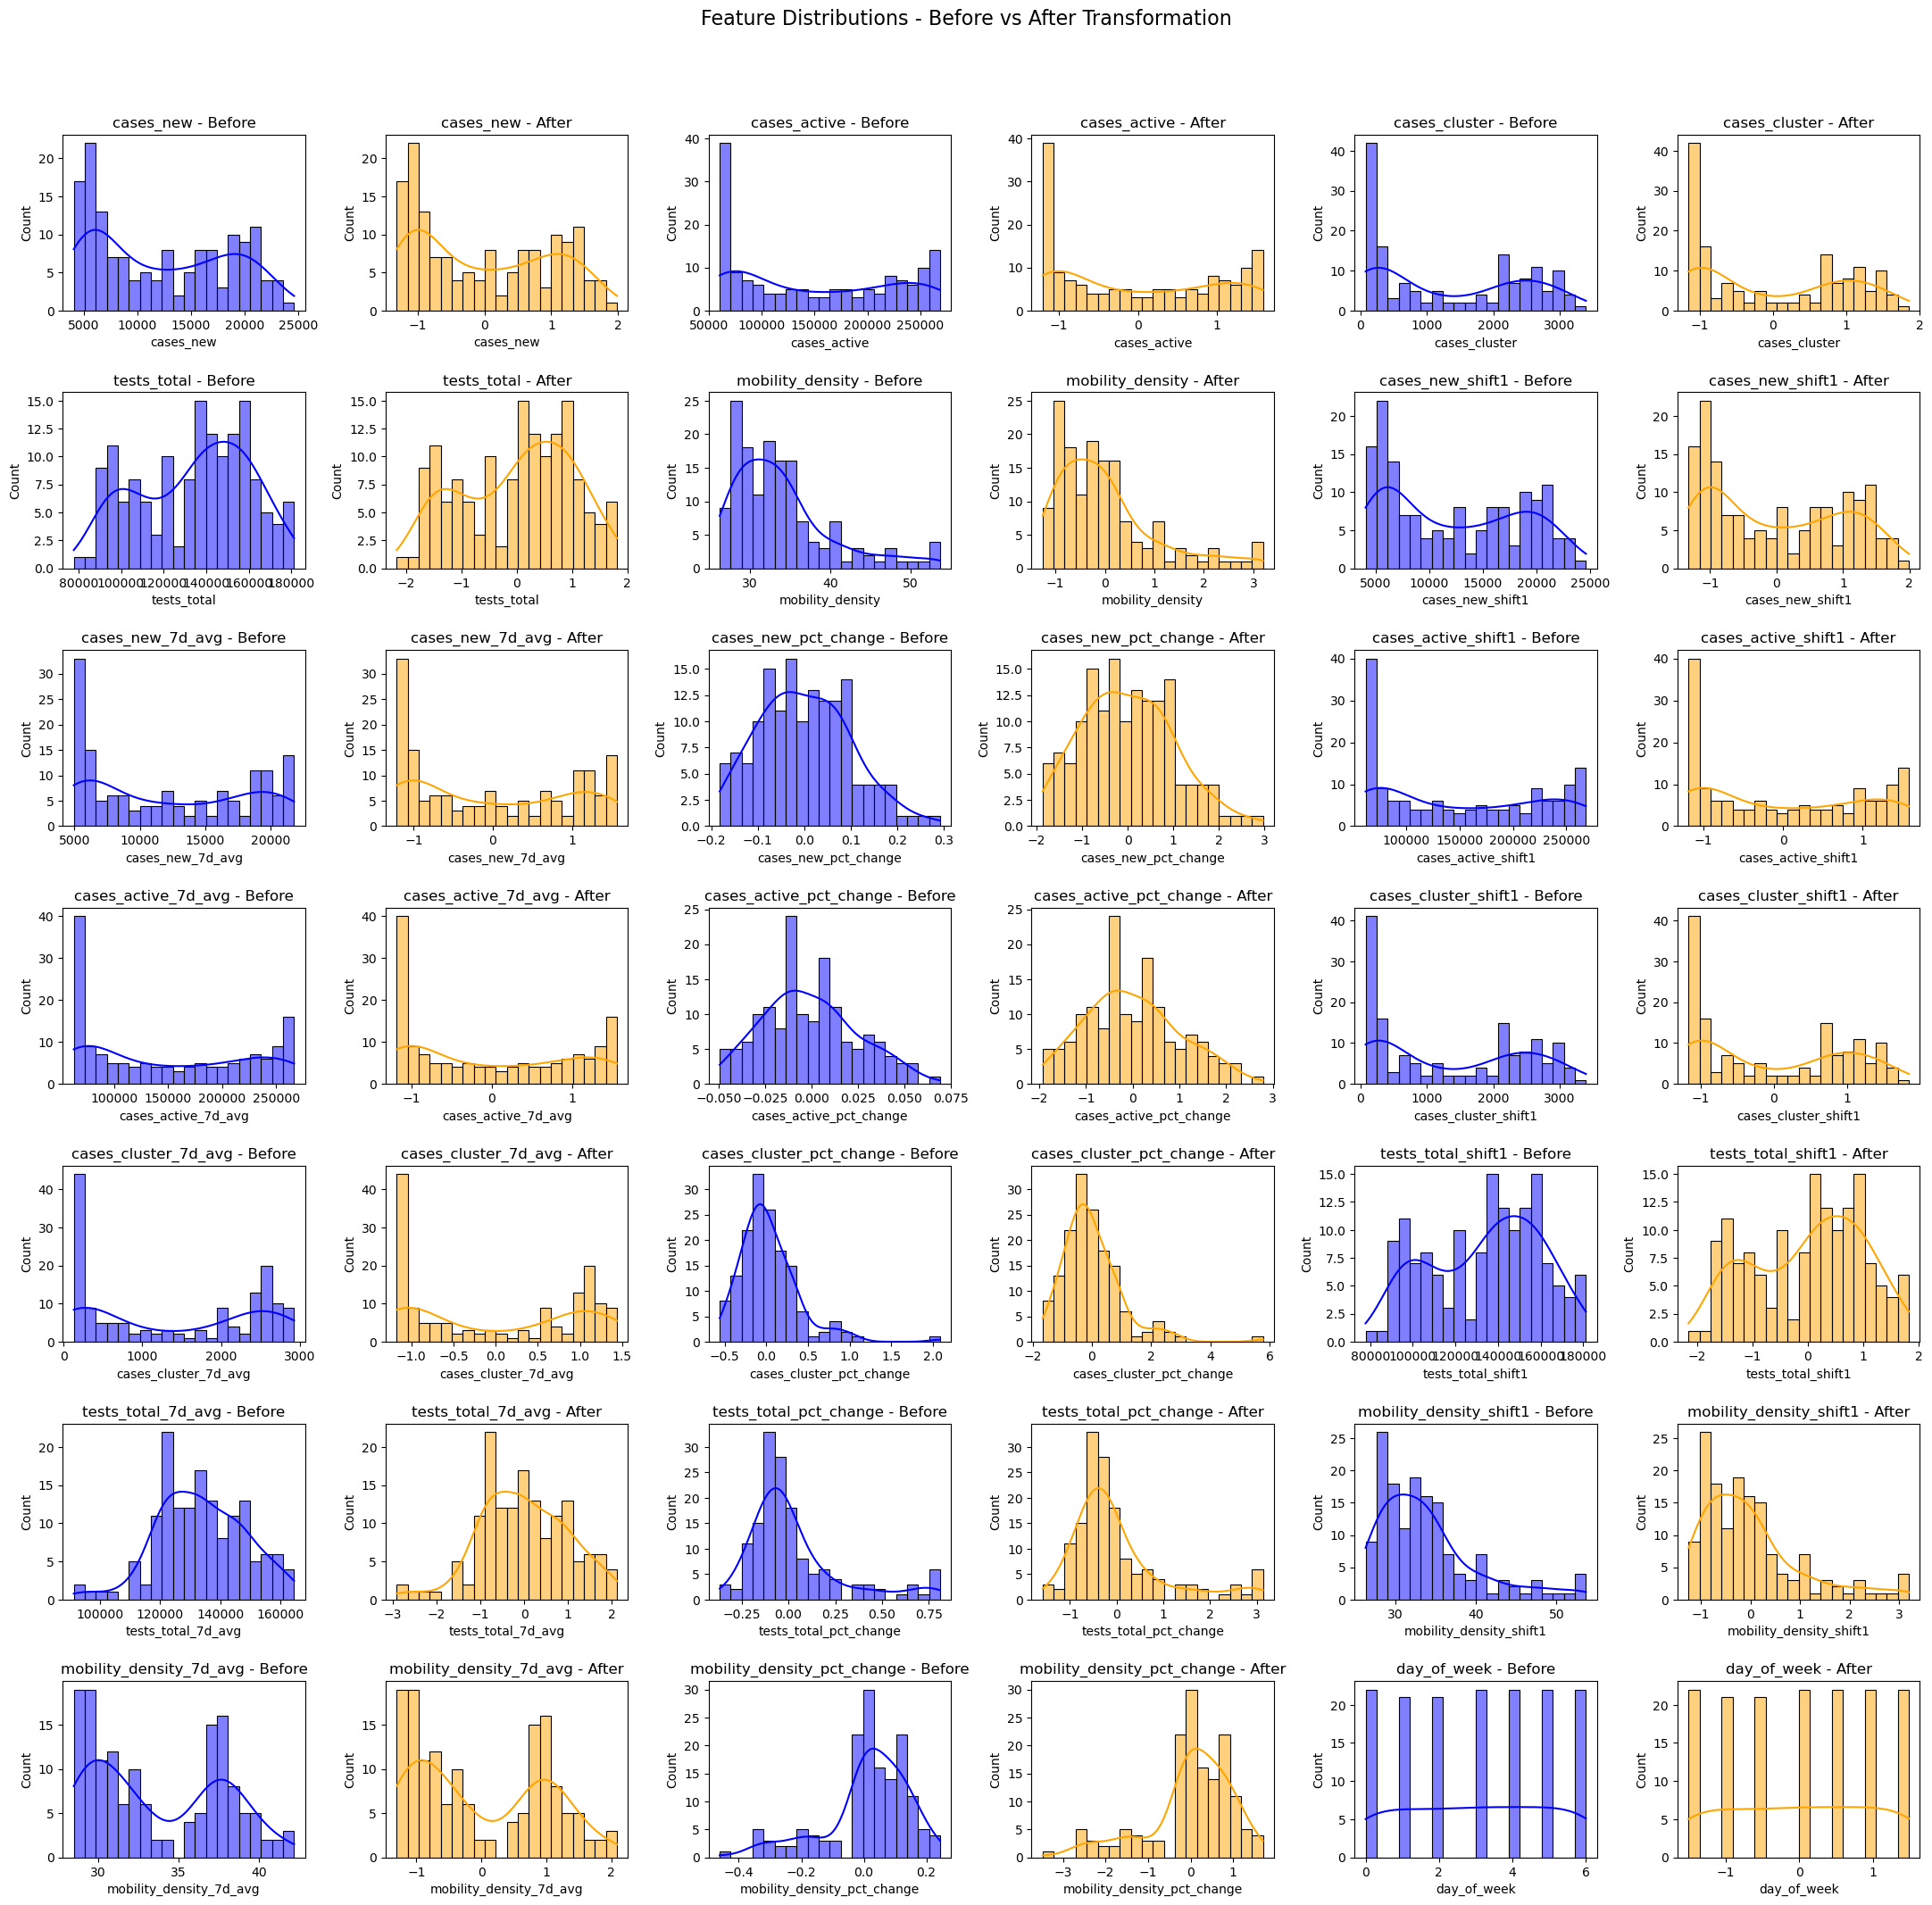

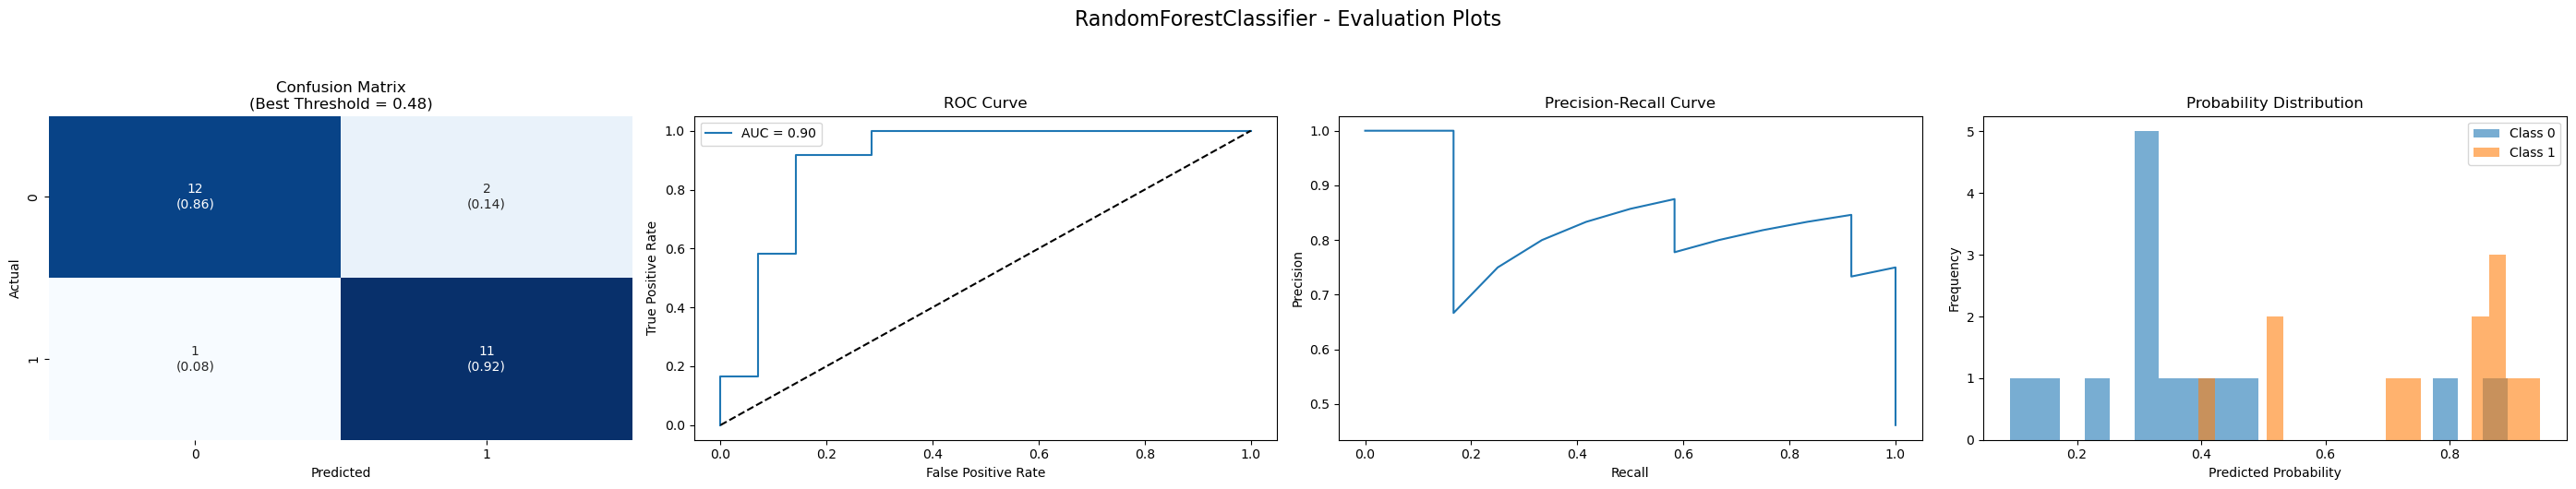


=== RandomForestClassifier Evaluation Summary ===
Best Params: {'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}

Best Threshold (by F1): 0.48
    Accuracy : 0.8846
    Precision: 0.8462
    Recall   : 0.9167
    F1-Score : 0.8800
    ROC-AUC  : 0.8988

Confusion Matrix (Counts):
[[12  2]
 [ 1 11]]

Confusion Matrix (Normalized):
[[0.86 0.14]
 [0.08 0.92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.85      0.92      0.88        12

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.88        26


Training Time : 35.64 sec
Inference Time: 0.0737 sec


=== Finished RandomForestClassifier ===

--- Running XGB ---

=== Training XGBClassifier with TimeSeriesSplit ===


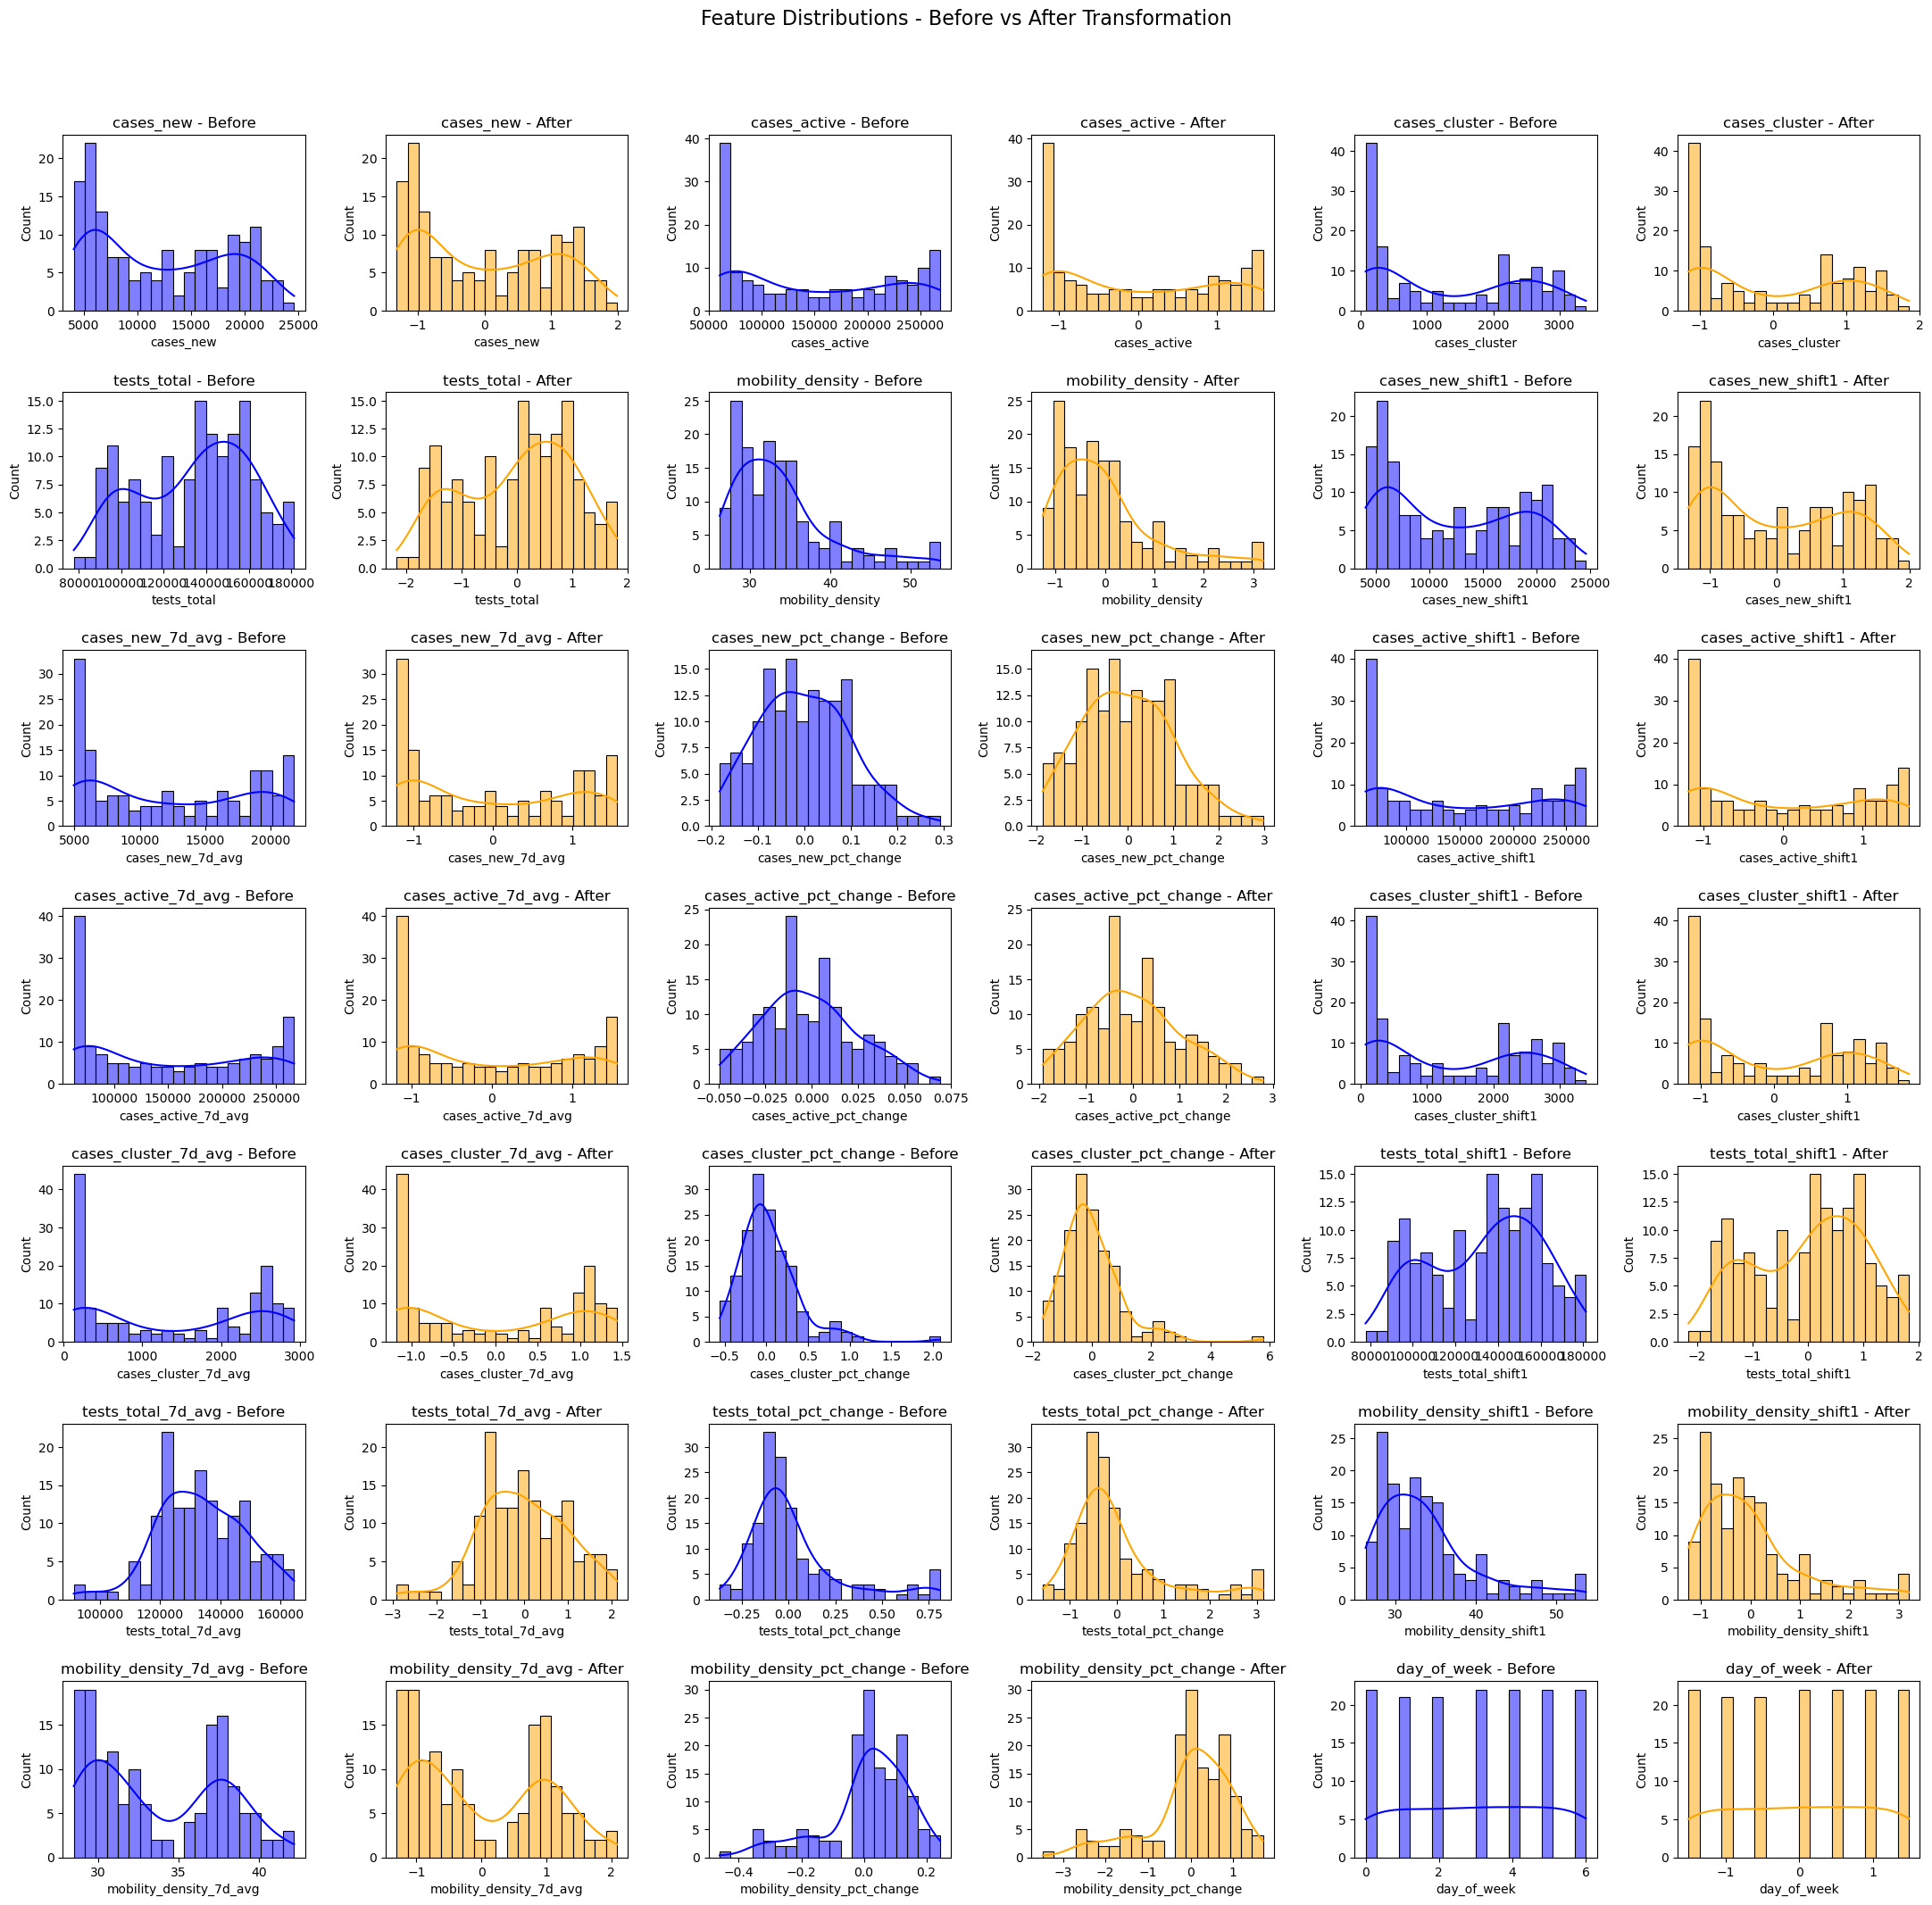

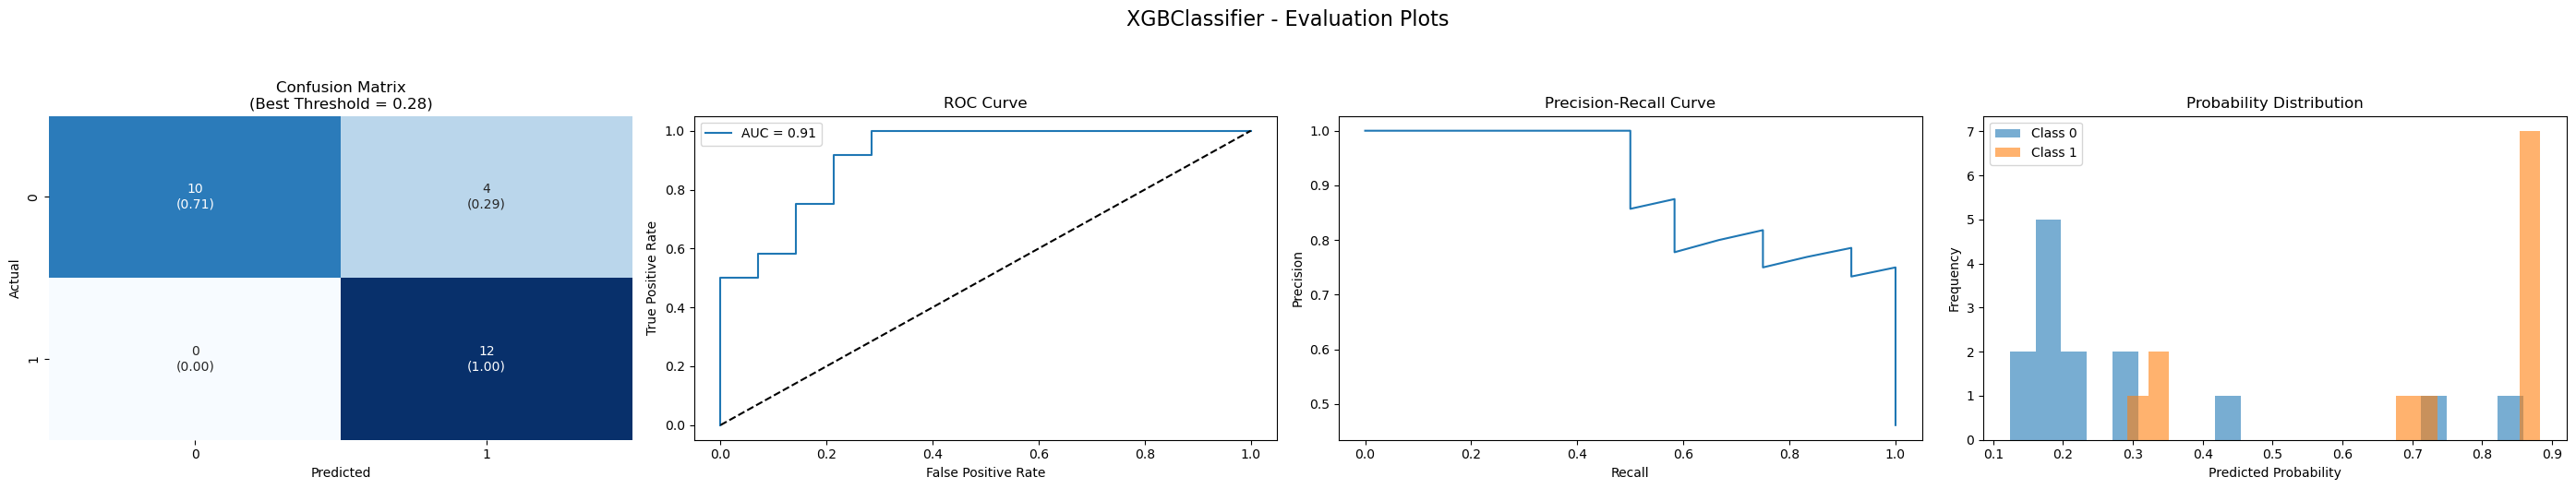


=== XGBClassifier Evaluation Summary ===
Best Params: {'model__colsample_bytree': 0.7, 'model__gamma': 0, 'model__learning_rate': 0.025, 'model__max_depth': 4, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 3, 'model__subsample': 0.6}

Best Threshold (by F1): 0.28
    Accuracy : 0.8462
    Precision: 0.7500
    Recall   : 1.0000
    F1-Score : 0.8571
    ROC-AUC  : 0.9107

Confusion Matrix (Counts):
[[10  4]
 [ 0 12]]

Confusion Matrix (Normalized):
[[0.71 0.29]
 [0.00 1.00]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        14
           1       0.75      1.00      0.86        12

    accuracy                           0.85        26
   macro avg       0.88      0.86      0.85        26
weighted avg       0.88      0.85      0.84        26


Training Time : 98.69 sec
Inference Time: 0.0034 sec


=== Finished XGBClassifier ===

Results per model:
                model  accuracy  pr

In [52]:
# MODEL TRAINING & EVALUATIONS
all_results = []
all_avg = []

for i, (name, model) in enumerate(models.items()):
    print(f"\n--- Running {name} ---")

    # Choose transformation (LogisticRegression benefits most from Yeo-Johnson)
    if name == "LogisticRegression":
        transform = "yeo-johnson"
    else:
        transform = None

    df_result, df_avg = train_evaluate_model(
        model=model,
        param_grid=param_grids[name],
        X=X,
        y=y,
        n_splits=5,
        test_fraction=0.15,
        transform=transform,
    )

    # Tag model name explicitly
    df_result["model"] = name
    df_avg["model"] = name
    all_results.append(df_result)
    all_avg.append(df_avg)

# Combine all results
df_results_combined = pd.concat(all_results, ignore_index=True)
df_avg_combined = pd.concat(all_avg, ignore_index=True)

# Display
print("\nResults per model:")
print(df_results_combined)
print("\nAverage metrics per model:")
print(df_avg_combined)